In [2]:
%env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
%env LLM_API_KEY=替换为自己的key

env: LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
env: LLM_API_KEY=替换为自己的key


In [2]:
%%capture --no-stderr
!pip install -U langchain langchain_community langchain_openai pypdf sentence_transformers chromadb shutil openpyxl

In [3]:
import langchain, langchain_community, pypdf, sentence_transformers, chromadb, langchain_core

for module in (langchain, langchain_core, langchain_community, pypdf, sentence_transformers, chromadb):
    print(f"{module.__name__:<30}{module.__version__}")

/opt/anaconda3/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-08-18 22:43:46.467817: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-18 22:43:46.499171: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-18 22:43:47.095997: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


langchain                     0.2.10
langchain_core                0.2.28
langchain_community           0.2.9
pypdf                         4.3.1
sentence_transformers         3.0.1
chromadb                      0.5.4


In [4]:
import os
import pandas as pd

In [5]:
expr_version = 'retrieval_v3_rag_fusion'

preprocess_output_dir = os.path.join(os.path.pardir, 'outputs', 'v1_20240713')
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

# 读取文档

In [6]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(os.path.join(os.path.pardir, 'data', '2024全球经济金融展望报告.pdf'))
documents = loader.load()

qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))

# 文档切分

In [7]:
from uuid import uuid4
import os
import pickle

from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_docs(documents, filepath, chunk_size=400, chunk_overlap=40, seperators=['\n\n\n', '\n\n'], force_split=False):
    if os.path.exists(filepath) and not force_split:
        print('found cache, restoring...')
        return pickle.load(open(filepath, 'rb'))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=seperators
    )
    split_docs = splitter.split_documents(documents)
    for chunk in split_docs:
        chunk.metadata['uuid'] = str(uuid4())

    pickle.dump(split_docs, open(filepath, 'wb'))

    return split_docs

In [8]:
splitted_docs = split_docs(documents, os.path.join(preprocess_output_dir, 'split_docs.pkl'), chunk_size=500, chunk_overlap=50)

found cache, restoring...


# 检索

In [9]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import Chroma
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

def get_embeddings(model_path):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_path,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': True},
        # show_progress=True
        query_instruction='为这个句子生成表示以用于检索相关文章：'
    )
    return embeddings

device: cuda


In [10]:
import shutil
from langchain_community.vectorstores import Chroma

model_path = 'BAAI/bge-large-zh-v1.5'

persist_directory = os.path.join(expr_dir, 'chroma')
shutil.rmtree(persist_directory, ignore_errors=True)

embeddings = get_embeddings(model_path)
vector_db = Chroma.from_documents(
    splitted_docs,
    embedding=embeddings,
    persist_directory=persist_directory
)

In [11]:
test_df = qa_df[(qa_df['dataset'] == 'test') & (qa_df['qa_type'] == 'detailed')]

## 不使用RAG Fusion

In [12]:
def get_emb_retriever(k):
    return vector_db.as_retriever(search_kwargs={'k': k})

In [13]:
from tqdm.auto import tqdm

def get_hit_stat_df(get_retriever_fn, top_k_arr=list(range(1, 9))):
    hit_stat_data = []
    pbar = tqdm(total=len(top_k_arr) * len(test_df))
    for k in top_k_arr:
        pbar.set_description(f'k={k}')
        retriever = get_retriever_fn(k)
        
        for idx, row in test_df.iterrows():
            question = row['question']
            true_uuid = row['uuid']
            
            chunks = retriever.invoke(question)[:k]
            retrieved_uuids = [doc.metadata['uuid'] for doc in chunks]

            hit_stat_data.append({
                'question': question,
                'top_k': k,
                'hit': int(true_uuid in retrieved_uuids),
                'retrieved_chunks': len(chunks)
            })
            pbar.update(1)
    hit_stat_df = pd.DataFrame(hit_stat_data)
    return hit_stat_df

In [14]:
orig_query_hit_stat_df = get_hit_stat_df(get_emb_retriever)
orig_query_hit_stat_df['rag_fusion'] = 'w/o'

  0%|          | 0/744 [00:00<?, ?it/s]

## 使用RAG Fusion

In [15]:
from langchain_community.chat_models import ChatOllama
from langchain.prompts import PromptTemplate
import re

llm = ChatOllama(base_url='http://localhost:11434', model='qwen2:7b-instruct')

prompt = PromptTemplate(
    input_variables=['question', 'n_sim_query'],
    template = """你是一个AI语言模型助手。你的任务是基于给定的原始问题，再生成出来最相似的{n_sim_query}个不同的版本。\
你的目标是通过生成用户问题不同视角的版本，帮助用户克服基于距离做相似性查找的局限性。\
使用换行符来提供这些不同的问题，使用换行符来切分不同的问题，不要包含数字序号，仅返回结果即可，不要添加任何其他描述性文本。
原始问题：{question}
"""
)

generate_queries_chain = (
    prompt
    | llm
    # 有时候模型不遵循指令，把前面的序号去掉
    # | (lambda x: re.sub(r'\d+\.\s', '', x.content))
    # 有时候模型不遵循指令，把前面的序号、- 去掉
    | (lambda x: [
        re.sub(r'(^\-\s+)|(^\d+\.\s)', '', item.strip()) 
        for item in x.content.split('\n') if item.strip() != ''
    ])
)

In [16]:
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    fused_scores = {}
    for docs in results:
        # 此处有一个隐含的假设：返回的docs是按相似度排好序的
        for rank, doc in enumerate(docs):
            doc_str = dumps(doc)
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # previous_score = fused_scores[doc_str]
            fused_scores[doc_str] += 1 / (rank + k)
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]
    return reranked_results

In [17]:
def get_rag_fusion_chain(top_k, n_sim_query=3, trunc=False):
    """
    获取RAG Fusion Chain
    :param top_k: 每个相似问检索的片段数量
    :param trunc: 最终排序后的结果是否要截断为top_k
    """
    chain = (
        prompt.partial(n_sim_query=n_sim_query)
        | llm
        # 有时候模型不遵循指令，把前面的序号去掉
        # | (lambda x: re.sub(r'\d+\.\s', '', x.content))
        # 有时候模型不遵循指令，把前面的序号、- 去掉
        | (lambda x: [
            re.sub(r'(^\-\s+)|(^\d+\.\s)', '', item.strip()) 
            for item in x.content.split('\n') if item.strip() != ''])
        | (lambda x: [vector_db.similarity_search(q, k=top_k) for q in x])
        | reciprocal_rank_fusion
        | (lambda docs: docs[:top_k] if trunc else docs)
    )
    return chain

首先先生成相似问题，这个跟Multi Query是类似的

In [18]:
generate_queries_chain.invoke({'question': '报告的发布机构是什么？', 'n_sim_query': 3})

['报告是由哪个组织发布的？', '谁能找到报告的来源？', '什么实体负责公布这份报告？']

查看一下中间过程，这个步骤，对于每一个产生的相似问题，检索5个片段

In [19]:
retrieved_docs = (
    generate_queries_chain
    | (lambda x: [vector_db.similarity_search(q, k=5) for q in x])
).invoke({'question': '报告的发布机构是什么？', 'n_sim_query': 3})

In [20]:
len(retrieved_docs)

3

In [21]:
len(retrieved_docs[0])

5

In [22]:
len(get_rag_fusion_chain(3).invoke({'question': '报告的发布机构是什么？'}))

/opt/anaconda3/lib/python3.10/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


4

如果确认rag_fusion_chain没有问题，可以直接设置trunc为True，确保召回数量符合设定值

In [23]:
get_rag_fusion_chain(2, trunc=True).invoke({'question': '报告的发布机构是什么？'})

[(Document(metadata={'page': 33, 'source': 'data/2024全球经济金融展望报告.pdf', 'uuid': '3e312dfa-dd43-4ab9-961f-a2e442c89cdd'}, page_content='全球经济金融展望报告\n中国银行研究院 32 2024年\n图19：美国联邦基金目标利率与全球MSCI指数\n资料来源：Wind，中国银行研究院\n表3：全球主要股指概览\n注：涨跌幅区间为2023年1月1日至2023年11月15日，收盘价和市盈\n率为2023年11月15日。\n资料来源：Wind，中国银行研究院'),
  0.04972677595628415),
 (Document(metadata={'page': 51, 'source': 'data/2024全球经济金融展望报告.pdf', 'uuid': 'ebf0d999-59f6-4fd3-941e-05a7a60c255a'}, page_content='免责声明\n本研究报告由中国银行研究院撰写，研究报告中所引用信息均来自公开资料。\n本研究报告中包含的观点或估计仅代表作者迄今为止的判断，它们不一定反映中国银行的观点。中国\n银行研究院可以不经通知加以改变，且没有对此报告更新、修正或修改的责任。\n本研究报告内容及观点仅供参考，不构成任何投资建议。对于本报告所提供信息所导致的任何直接的\n或者间接的投资盈亏后果不承担任何责任。\n本研究报告版权仅为中国银行研究院所有，未经书面许可，任何机构和个人不得以任何形式翻版、复\n制和发布。如引用发布，需注明出处为中国银行研究院，且不得对本报告进行有悖原意的引用、删节和修\n改。中国银行研究院保留对任何侵权行为和有悖报告原意的引用行为进行追究的权利。'),
  0.03278688524590164)]

为了方便调参，我们创建一个新的函数，使用下面这个函数

In [24]:
def retrieve_with_rrf(llm, query, top_k=4, n_sim_query=3, include_original=True, trunc=True):
    """
    使用RRF检索
    :param llm: 用于生成相似问题的LLM
    :param query: 需要检索的问题
    :param top_k: 每个问题检索几个知识片段
    :param n_sim_query: 每个query生成几个相似问题
    :param include_original: 检索知识片段时，是否包含原始问题
    :param trunc: 是否将最终检索结果，截断为top_k
    """
    chain = (
        prompt.partial(n_sim_query=n_sim_query)
        | llm
        # 有时候模型不遵循指令，把前面的序号、- 去掉
        | (lambda x: [
            re.sub(r'(^\-\s+)|(^\d+\.\s)', '', item.strip()) 
            for item in x.content.split('\n') if item.strip() != ''])
        | (lambda x: [vector_db.similarity_search(q, k=top_k) for q in ([query] if include_original else []) + x[:n_sim_query]])
        | reciprocal_rank_fusion
        | (lambda docs: docs[:top_k] if trunc else docs)
    )
    return chain.invoke(query)

In [25]:
def get_rag_fusion_hit_stat_df(query_gen_llm, top_k_arr=list(range(1, 9))):
    hit_stat_data = []
    pbar = tqdm(total=len(top_k_arr) * len(test_df))
    for k in top_k_arr:
        pbar.set_description(f'k={k}')
        rag_fusion_chain = get_rag_fusion_chain(k, trunc=True)
        for idx, row in test_df.iterrows():
            question = row['question']
            true_uuid = row['uuid']
            # chunks = rag_fusion_chain.invoke({'question': question})
            chunks = retrieve_with_rrf(query_gen_llm, question, top_k=k)
            assert len(chunks) <= k
            
            retrieved_uuids = [doc.metadata['uuid'] for doc, score in chunks]

            hit_stat_data.append({
                'question': question,
                'top_k': k,
                'hit': int(true_uuid in retrieved_uuids),
                'retrieved_chunks': len(chunks)
            })
            pbar.update(1)
    hit_stat_df = pd.DataFrame(hit_stat_data)
    return hit_stat_df

In [26]:
from langchain_openai import ChatOpenAI

qwen2_14b_llm = ChatOpenAI(
    base_url=os.environ['LLM_BASE_URL'],
    api_key=os.environ['LLM_API_KEY'],
    model='qwen2-57b-a14b-instruct'
)

rag_fusion_hit_stat_dfs = []
for llm_name, llm_model in zip(['ollama-qwen2-7b-instruct', 'qwen2-57b-a14b-instruct'], [llm, qwen2_14b_llm]):
    rag_fusion_hit_stat_df = get_rag_fusion_hit_stat_df(llm_model)
    rag_fusion_hit_stat_df['rag_fusion'] = f'w/ {llm_name}'
    rag_fusion_hit_stat_dfs.append(rag_fusion_hit_stat_df)

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

In [27]:
hit_stat_df = pd.concat([orig_query_hit_stat_df] + rag_fusion_hit_stat_dfs)

In [28]:
hit_stat_df.groupby(['rag_fusion', 'top_k'])['hit'].mean().reset_index().rename(columns={'hit': 'hit_rate'})

,rag_fusion,top_k,hit_rate
0,w/ ollama-qwen2-7b-instruct,1,0.451613
1,w/ ollama-qwen2-7b-instruct,2,0.591398
2,w/ ollama-qwen2-7b-instruct,3,0.666667
3,w/ ollama-qwen2-7b-instruct,4,0.741935
4,w/ ollama-qwen2-7b-instruct,5,0.806452
5,w/ ollama-qwen2-7b-instruct,6,0.784946
6,w/ ollama-qwen2-7b-instruct,7,0.817204
7,w/ ollama-qwen2-7b-instruct,8,0.838710
8,w/ qwen2-57b-a14b-instruct,1,0.462366
9,w/ qwen2-57b-a14b-instruct,2,0.580645


<Axes: xlabel='top_k', ylabel='hit'>

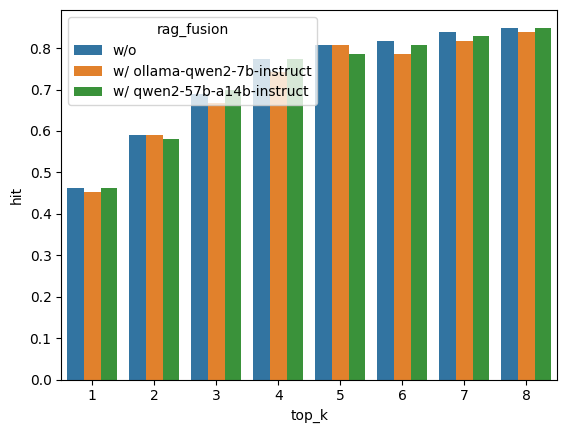

In [29]:
import seaborn as sns

sns.barplot(x='top_k', y='hit', hue='rag_fusion', data=hit_stat_df, errorbar=None)

# 预测

In [30]:
from langchain.llms import Ollama

ollama_llm = Ollama(
    model='qwen2:7b-instruct',
    base_url='http://localhost:11434'
)

In [31]:
ollama_llm.invoke('你是谁')

'我是阿里云开发的一款超大规模语言模型，我叫通义千问。作为一个AI助手，我的目标是帮助用户获得准确、有用的信息，解决他们的问题和困惑。我会不断学习和进步，努力提供更好的服务。如果您有任何问题或需要帮助，请随时告诉我，我会尽力提供支持。'

In [32]:
def rag(query_gen_llm, question, n_chunks=3):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{question}}
请回答：
""".strip()

    # rag_fusion_chain = get_rag_fusion_chain(n_chunks, trunc=True)
    # chunks = rag_fusion_chain.invoke({'question': question})
    
    chunks = retrieve_with_rrf(query_gen_llm, question, top_k=n_chunks)
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([pair[0].page_content for pair in chunks])).replace('{{question}}', question)

    return ollama_llm(prompt), chunks

In [34]:
print(rag(llm, '2023年10月美国ISM制造业PMI指数较上月有何变化？')[0])

/opt/anaconda3/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


2023年10月，美国ISM制造业PMI指数较上个月大幅下降了2.3个百分点。


In [35]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

def predict(query_gen_llm, prediction_df, n_chunks):
    prediction_df = prediction_df.copy()
    answer_dict = {}

    for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        uuid = row['uuid']
        question = row['question']
        answer, chunks = rag(query_gen_llm, question, n_chunks=n_chunks)
        assert len(chunks) <= n_chunks
        answer_dict[question] = {
            'uuid': uuid,
            'ref_answer': row['ref_answer'],
            'gen_answer': answer,
            'chunks': chunks
        }
    prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
    prediction_df.loc[:, 'chunks'] = prediction_df['question'].apply(lambda q: answer_dict[q]['chunks'])

    return prediction_df

In [36]:
n_chunks = 3

pred_df_dict = {}
for llm_name, llm_model in zip(['ollama-qwen2-7b-instruct', 'qwen2-57b-a14b-instruct'], [llm, qwen2_14b_llm]):
    pred_df_dict[llm_name] = predict(llm_model, prediction_df, n_chunks=n_chunks)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# 评估

In [37]:
from langchain_openai import ChatOpenAI
import time

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='qwen2-72b-instruct',
    temperature=0
)

def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()
        result = judge_llm.invoke(prompt).content
        results.append(result)

        time.sleep(1)
    return results

In [39]:
for model_name, pred_df in pred_df_dict.items():
    pred_df['raw_score'] = evaluate(pred_df)
    print(f"{model_name}: {pred_df['raw_score'].unique()}")
    pred_df.loc[:, 'score'] = pred_df['raw_score'].replace({'是': 1, '否': 0})

  0%|          | 0/100 [00:00<?, ?it/s]

ollama-qwen2-7b-instruct: ['是' '否']


/tmp/ipykernel_2336286/2492278847.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pred_df.loc[:, 'score'] = pred_df['raw_score'].replace({'是': 1, '否': 0})


  0%|          | 0/100 [00:00<?, ?it/s]

qwen2-57b-a14b-instruct: ['是' '否']


/tmp/ipykernel_2336286/2492278847.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pred_df.loc[:, 'score'] = pred_df['raw_score'].replace({'是': 1, '否': 0})


In [40]:
pred_df_dict['ollama-qwen2-7b-instruct']['score'].mean()

0.69

In [41]:
pred_df_dict['qwen2-57b-a14b-instruct']['score'].mean()

0.69

In [ ]:
for model_name, pred_df in pred_df_dict.items():
    pred_df.to_excel(os.path.join(expr_dir, f'prediction_{model_name}.xlsx'), index=False)